<h1 align=center><font size = 10> k-Means </font></h1>

In this notebook, we try to practice one of the most popular algorithms in Clustering that we learned in this course: k-Means algorithm. 

We load a dataset using Pandas library and apply k-Means to explore information from data.
Lets first load required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from sklearn.cluster import KMeans
matplotlib.style.use('ggplot') # Look Pretty
import warnings
warnings.filterwarnings("ignore")
def showandtell(title=None):
  plt.show()

A convenience function for you to use:

In [2]:
def clusterInfo(model):
    print("Cluster Analysis Inertia: ", model.inertia_)
    print('------------------------------------------')
    
    for i in range(len(model.cluster_centers_)):
        print("\n  Cluster ", i)
        print("    Centroid ", model.cluster_centers_[i])
        print("    #Samples ", (model.labels_==i).sum()) # NumPy Power

In [3]:
# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
    # Ensure there's at least on cluster...
    minSamples = len(model.labels_)
    minCluster = 0
    
    for i in range(len(model.cluster_centers_)):
        if minSamples > (model.labels_==i).sum():
            minCluster = i
            minSamples = (model.labels_==i).sum()

    print("\n  Cluster With Fewest Samples: ", minCluster)
    return (model.labels_==minCluster)

# Mandatory part (85%  of the total score)

### About dataset

A [call detail record](https://en.wikipedia.org/wiki/Call_detail_record) (CDR) is a data record produced by a telephone exchange or other telecommunications equipment that documents the details of a telephone call or other telecommunications transaction (e.g., text message) that passes through that facility or device.

The questions you'll be exploring in this lab assignment using K-Means are: exactly how useful is telephone metadata? It must have some use, otherwise, the government wouldn't have invested however many millions they did into it secretly collecting it from phone carriers. Also what kind of intelligence can you extract from CDR metadata besides its face value?

The record contains various attributes of the call, such as time, duration, completion status, source number, and destination number. It is the automated equivalent of the paper toll tickets that were written and timed by operators for long-distance calls in a manual telephone exchange.

The dataset we've curated for you contains call records of 10 people, tracked over the course of 3 years. Your job in this assignment is to find out where each of these people likely live and where they work at!


**1. Start by loading up the dataset and taking a peek at its head. You have to convert date-strings to real date-time objects using `pd.to_datetime`, and the times using `pd.to_timedelta`:**

In [4]:
#TO DO:
# load dữ liệu từ file csv trong cùng thư mục
df = pd.read_csv('CDR.csv')

# Chuyển đổi các cột CallDate bằng pd.to_datetime
df['CallDate'] = pd.to_datetime(df['CallDate'])

# Chuyển đổi các cột CallTime bằng pd.to_timedelta
df['CallTime'] = pd.to_timedelta(df['CallTime'])
df.head()

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,0 days 07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,0 days 21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,0 days 14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,0 days 16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,0 days 15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389


**2. Create a distinct list of `In` phone numbers (people) and store the values in a regular python list.**

Make sure the numbers appear in your list in the same order they appear in your dataframe; but only keep a single copy of each number. [This link](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html) might also be helpful.

In [5]:
#TO DO:
# Tạo list distinct các số điện thoại bằng hàm unique
phone_list = df.In.unique()
phone_list

array([4638472273, 1559410755, 4931532174, 2419930464, 1884182865,
       3688089071, 4555003213, 2068627935, 2894365987, 8549533077],
      dtype=int64)

**3. Create a slice named `user1` that filters to _only_ include dataset records where the `In` feature (user's phone number) is equal to the first number on your unique list above, i.e., the very first number in the dataset:**

In [6]:
#TO DO:
# tạo user1 gồm các bản ghi của người có số điện thoại đầu tiên
user1 = df[df.In == phone_list[0]]
print('Shape của dataframe user1 là:',user1.shape)

Shape của dataframe user1 là: (3648, 10)


**4. Let's go ahead and plot all the call locations for user 1 in all time:**


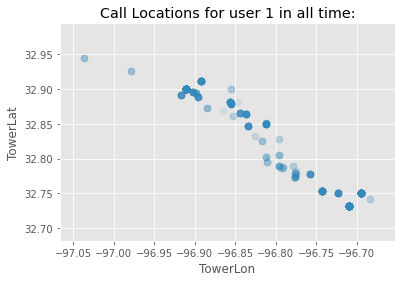

In [7]:
# Vẽ tất cả các vị trí cuộc gọi cho người dùng cho toàn bộ thời gian sử dụng scatter plot

plt.style.use('ggplot')

# dùng biểu đồ phân tán scatter plot tích hợp luôn trong pandas
user1.plot.scatter(x= 'TowerLon', y ='TowerLat', marker = 'o', 
                   alpha = 0.1, s = 50 )
plt.title('Call Locations for user 1 in all time:')

# set axis cho plot này
lons,lats = user1.TowerLon, user1.TowerLat
lonmin,lonmax,latmin,latmax = lons.min(),lons.max(),lats.min(),lats.max()
plt.axis((lonmin-0.03,lonmax+0.03,latmin-0.05,latmax+0.05))

plt.show();

INFO: The locations map above should be too "busy" to really wrap your head around. This is where domain expertise comes into play. Your intuition can direct you by knowing people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

**5. Add more filters to the `user1` slice you created. Add bitwise logic so that you only examine records that _came in_ on weekends (sat/sun):**

In [8]:
# lọc các bản ghi xuất hiện vào cuối tuần (Thứ Bảy và Chủ Nhật)

user1_weekend = user1[(user1.DOW == 'Sat') | (user1.DOW == 'Sun')]

print('Shape của dataframe user1 ngày cuối tuần là:', user1_weekend.shape)

Shape của dataframe user1 ngày cuối tuần là: (1141, 10)


**6. Further filter `user1` down for calls that came in either before 6am OR after 10pm (22:00:00).**

Even if you didn't convert your times from string objects to time deltas, you can still use `<` and `>` to compare the string times as long as you code them as [military time strings](https://en.wikipedia.org/wiki/24-hour_clock), eg: "06:00:00", "22:00:00": 

You may also want to review the Data Manipulation section for this. Once you have your filtered slice, print out its length:

In [9]:
# lọc user1 cho các cuộc gọi đến trước 6 giờ sáng HOẶC sau 10 giờ tối
# set điều kiện
before6 = user1_weekend.CallTime< datetime.timedelta(hours= 6)
after22 = user1_weekend.CallTime> datetime.timedelta(hours= 22)
# lọc
user1_night = user1_weekend[before6 | after22]

In [10]:
print('Tổng tất cả các cuộc gọi của user1:',len(user1))
print('Tổng các cuộc gọi của user1 trước 6 h sáng hoặc sau 22 h tối vào cuối tuần là :',len(user1_night))

Tổng tất cả các cuộc gọi của user1: 3648
Tổng các cuộc gọi của user1 trước 6 h sáng hoặc sau 22 h tối vào cuối tuần là : 28


**7. Visualize the dataframe with a scatter plot as a sanity check.**

Since you're [familiar with maps](https://en.wikipedia.org/wiki/Geographic_coordinate_system#Geographic_latitude_and_longitude), you know well that your X-Coordinate should be Longitude, and your Y coordinate should be the tower Latitude. Check the dataset headers for proper column feature names.
 
At this point, you don't yet know exactly where the user is located just based on the cell phone tower position data; but considering the below are for Calls that arrived in the twilight hours of weekends, it's likely that wherever they are bunched up is probably near where the caller's residence:

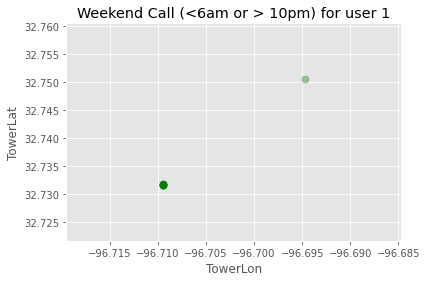

In [11]:
# trực quan hóa bằng scatter plot tích hợp trong pandas
user1_night.plot.scatter(x='TowerLon', y ='TowerLat', 
                         c= 'g',marker = 'o',alpha = 0.2, s= 50)

# set axis cho plot này
lons,lats = user1_night.TowerLon, user1_night.TowerLat
lonmin,lonmax,latmin,latmax = lons.min(),lons.max(),lats.min(),lats.max()
plt.axis((lonmin-0.01,lonmax+0.01,latmin-0.01,latmax+0.01))

plt.title('Weekend Call (<6am or > 10pm) for user 1');

**8. Run K-Means on that dataframe with `K=2` then print out the Cluster Info using clusterInfo function**, with the goal being that one of the centroids will sweep up the annoying outliers; and the other will zero in on the user's approximate home location. Or rather the location of the cell tower closest to their home.....

Be sure to only feed in Lat and Lon coordinates to the KMeans algorithm since none of the other data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale, no feature scaling is required.

In [12]:
X = user1_night[['TowerLat','TowerLon']]

# Chạy K-Means với K = 2
km = KMeans(n_clusters = 2)
km.fit(X)

KMeans(n_clusters=2)

In [13]:
# in ra Cluster Info
clusterInfo(km)

Cluster Analysis Inertia:  1.1304346153788861e-07
------------------------------------------

  Cluster  0
    Centroid  [ 32.73164942 -96.70944573]
    #Samples  26

  Cluster  1
    Centroid  [ 32.750556 -96.694722]
    #Samples  2


**9. Add centroid locations onto your scatter plot. Use a distinguishable marker and color.**

Hint: Make sure you graph the CORRECT coordinates. This is part of your domain expertise.

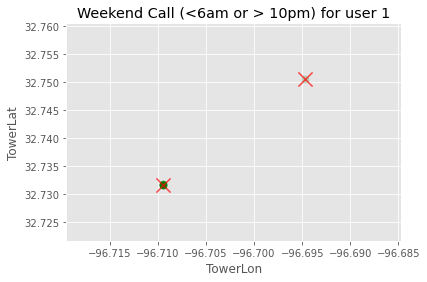

In [14]:
# trực quan hóa các điểm trong bộ dữ liệu user1 night
user1_night.plot.scatter(x='TowerLon', y ='TowerLat', 
                         c= 'g',marker = 'o',alpha = 0.1, s= 50)

# set axis
lons,lats = user1_night.TowerLon, user1_night.TowerLat
lonmin,lonmax,latmin,latmax = lons.min(),lons.max(),lats.min(),lats.max()
plt.axis((lonmin-0.01,lonmax+0.01,latmin-0.01,latmax+0.01))

# vẽ các centers bằng kí hiệu x
plt.scatter(x=km.cluster_centers_[:,1], y=km.cluster_centers_[:,0],
           marker = 'x', c = 'red', s = 200, alpha = 0.7)

plt.title('Weekend Call (<6am or > 10pm) for user 1');

**10. Now that you have a system in place, repeat the above steps (4, 8, and 9) for all 10 individuals in the dataset**. 

You might want to use a for-loop unless you enjoy copying and pasting:

User 1
Cluster Analysis Inertia:  1.1304346153788861e-07
------------------------------------------

  Cluster  0
    Centroid  [ 32.73164942 -96.70944573]
    #Samples  26

  Cluster  1
    Centroid  [ 32.750556 -96.694722]
    #Samples  2
None


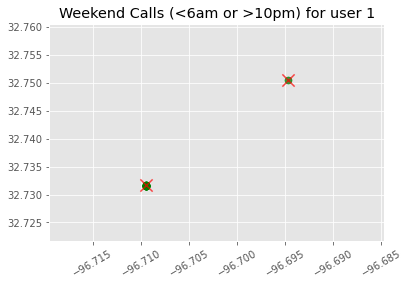



User 2
Cluster Analysis Inertia:  2.1113663366881182e-08
------------------------------------------

  Cluster  0
    Centroid  [ 32.87096756 -96.92355156]
    #Samples  101

  Cluster  1
    Centroid  [ 32.871111 -96.923556]
    #Samples  2
None


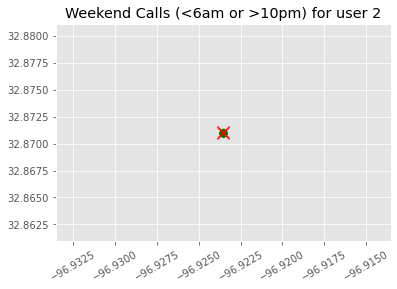



User 3
Cluster Analysis Inertia:  1.9522045272610653e-05
------------------------------------------

  Cluster  0
    Centroid  [ 32.86592718 -96.865298  ]
    #Samples  22

  Cluster  1
    Centroid  [ 32.857778 -96.864444]
    #Samples  1
None


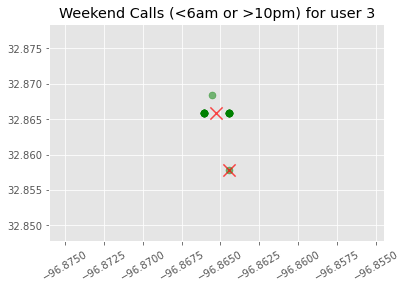



User 4
Cluster Analysis Inertia:  0.00020962809096294443
------------------------------------------

  Cluster  0
    Centroid  [ 32.84635163 -96.83515822]
    #Samples  27

  Cluster  1
    Centroid  [ 32.861222 -96.852389]
    #Samples  1
None


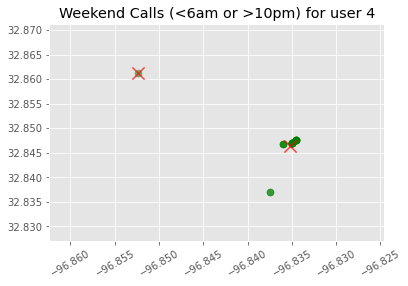



User 5
Cluster Analysis Inertia:  0.0
------------------------------------------

  Cluster  0
    Centroid  [ 32.875    -96.730278]
    #Samples  22

  Cluster  1
    Centroid  [ 32.917333 -96.759694]
    #Samples  1
None


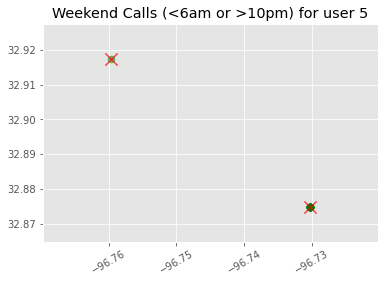



User 6
Cluster Analysis Inertia:  0.0
------------------------------------------

  Cluster  0
    Centroid  [ 32.770833 -96.685556]
    #Samples  18

  Cluster  1
    Centroid  [ 32.770833 -96.685556]
    #Samples  0
None


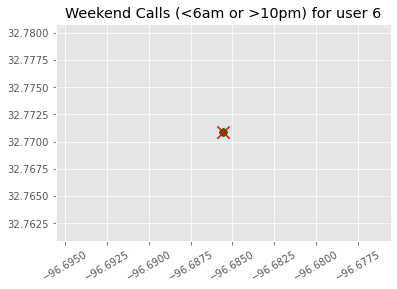



User 7
Cluster Analysis Inertia:  0.0
------------------------------------------

  Cluster  0
    Centroid  [ 32.705222 -96.840667]
    #Samples  11

  Cluster  1
    Centroid  [ 32.695    -96.840556]
    #Samples  1
None


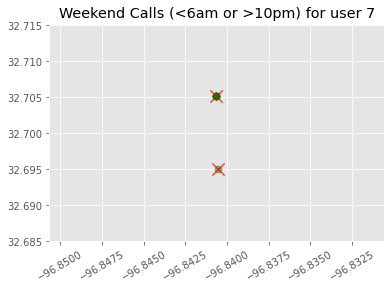



User 8
Cluster Analysis Inertia:  1.5557538194652854e-58
------------------------------------------

  Cluster  0
    Centroid  [ 32.703056 -96.604444]
    #Samples  50

  Cluster  1
    Centroid  [ 32.703056 -96.604444]
    #Samples  0
None


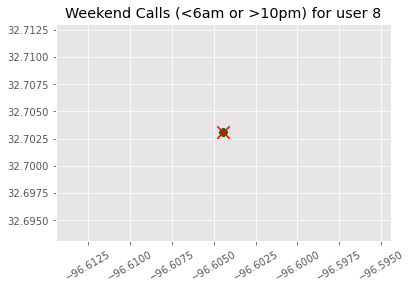



User 9
Cluster Analysis Inertia:  0.0009926468224979467
------------------------------------------

  Cluster  0
    Centroid  [ 32.77401172 -96.81277401]
    #Samples  106

  Cluster  1
    Centroid  [ 32.702    -96.920139]
    #Samples  2
None


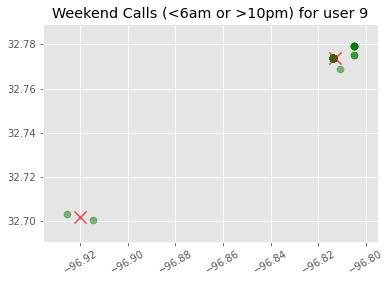



User 10
Cluster Analysis Inertia:  0.0028743288811454095
------------------------------------------

  Cluster  0
    Centroid  [ 32.7722949  -96.77946848]
    #Samples  63

  Cluster  1
    Centroid  [ 33.01525  -96.831472]
    #Samples  1
None


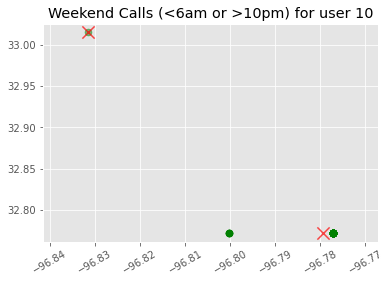

In [15]:
# dùng vòng lặp for cho tất cả 10 người
for user_code,phone in enumerate(phone_list):
    # lọc theo số điện thoại, cuối tuần và trước 6am và sau 22h (10pm)
    user = df[df.In == phone]
    user = user[(user.DOW == 'Sat') | (user.DOW == 'Sun')]
    less_6h = user.CallTime < datetime.timedelta(hours = 6)
    greater_22h = user.CallTime > datetime.timedelta(hours=22) 
    user = user[less_6h | greater_22h]
    
    #lấy 2 feature là long và lat
    X = user[['TowerLat','TowerLon']].values
    
    #dùng thuật toán kmeans với số cụm chỉ định là 2
    km = KMeans(n_clusters = 2, init = 'k-means++')
    km.fit(X)
    print('User',user_code+1)
    
    #dùng hàm cluster info để in thông tin cụm
    print(clusterInfo(km))
    
    # trực quan hóa tất cả các điểm
    plt.scatter(x=X[:,1],y=X[:,0], c='green', alpha = 0.5, s=50)
    
    # trực quan hóa centers
    centers = km.cluster_centers_
    plt.scatter(x=centers[:,1], y = centers[:,0], c='red',
                marker= 'x', alpha = 0.7, s =150)
    
    #set axis
    latmin,latmax,longmin,longmax = X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()
    plt.axis((longmin-0.01,longmax+0.01,latmin-0.01,latmax+0.01))
    
    
    plt.title('Weekend Calls (<6am or >10pm) for user %s' %str(user_code+1))
    plt.xticks(rotation = 30)
    plt.show()
    print('\n')

**11. Alter your slice from user1, so that it includes only Weekday (Mon-Fri) values and before 5pm:**

The idea is that the call was placed before 5pm. From Midnight-730a, the user is probably sleeping and won't call/wake up to take a call. There should be a brief time in the morning during their commute to work, then they'll spend the entire day at work. So the assumption is that most of the time is spent either at work or at the second, at home:
        

In [16]:
# lọc user1 theo ngày trong tuần(Thứ Hai-Thứ Sáu) và trước 5 giờ chiều.
user1_dayweek = user1[(user1.DOW != 'Sat') & (user1.DOW != 'Sun')]
less_17h = user1_dayweek.CallTime < datetime.timedelta(hours = 17)
user1_dayweek = user1_dayweek[less_17h]

print('shape dataframe user1 day of week and before 17h:', user1_dayweek.shape)

shape dataframe user1 day of week and before 17h: (1405, 10)


**12. Plot the Cell Towers the above data frame:**


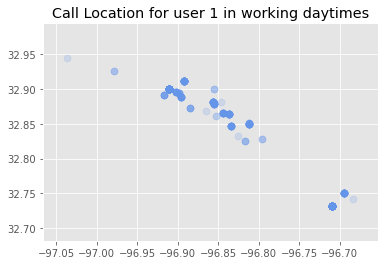

In [17]:
plt.style.use('ggplot')
X = user1_dayweek[['TowerLon','TowerLat']].values

# dùng scatter plot
plt.scatter(x = X[:,0], y = X[:,1] ,c ='cornflowerblue', marker ='o',
           s=50, alpha = 0.2)

# set axis
lonmin, lonmax, latmin, latmax = X[:,0].min(),X[:,0].max(), X[:,1].min(), X[:,1].max()
plt.axis((lonmin-0.03,lonmax+0.03,latmin-0.05,latmax+0.05))

plt.title('Call Location for user 1 in working daytimes');

**13. Complete the doKmeans function:**

In [18]:
#TO DO: Hoàn thành hàm doKmeans

def doKMeans(data, num_clusters=0):
    # TODO: Be sure to only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
    # data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale,
    # no feature scaling is required. Print out the centroid locations and add them onto your scatter
    # plot. Use a distinguishable marker and color.
    #
    # Hint: Make sure you fit ONLY the coordinates, and in the CORRECT order (lat first). This is part
    # of your domain expertise. Also, *YOU* need to create, initialize (and return) the variable named
    # `model` here, which will be a SKLearn K-Means model for this to work:
    
    # .. your code here ..
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters = num_clusters)
    X = data[['TowerLat','TowerLon']].values
    model.fit(X)
    return model

**14. Let's tun K-Means with `K=3`using doKMeans function for that dataframe (user1 on weekdays in daytime). Then print out the cluster info using clusterInfo function:**

There should only be two areas of concentration. If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another).

In [19]:
# k = 3 sử dụng hàm doKMeans

model = doKMeans(user1_dayweek, num_clusters=3)

In [20]:
# In ra thông tin cụm sử dụng hàm clusterInfo
clusterInfo(model)

Cluster Analysis Inertia:  0.1589106952378091
------------------------------------------

  Cluster  0
    Centroid  [ 32.86348712 -96.83818346]
    #Samples  140

  Cluster  1
    Centroid  [ 32.73323174 -96.70816184]
    #Samples  306

  Cluster  2
    Centroid  [ 32.9000009  -96.90951639]
    #Samples  959


**15. Print out the mean `CallTime` value for the samples belonging to the cluster with the LEAST samples attached to it.** 

If our logic is correct, the cluster with the MOST samples will be work. The cluster with the 2nd most samples will be home. And the `K=3` cluster with the least samples should be somewhere in between the two. What time, on average, is the user in between home and work, between midnight and 5pm?

In [21]:
# In ra trung bình của giá trị CallTime
# sử dụng hàm clusterWithFewestSamples để trả về dãy true false trong đó true là cho các điểm trong sample nhỏ nhất
least_sample = clusterWithFewestSamples(model)

print('Its Waypoint Time: ',user1_dayweek[least_sample]['CallTime'].mean())


  Cluster With Fewest Samples:  0
Its Waypoint Time:  0 days 07:49:53.168115942


**16. Let's visualize the results by drawing the X's for the cluster centers combined with location plot:**


Text(0.5, 1.0, 'Weekday Calls Centroids for user 1')

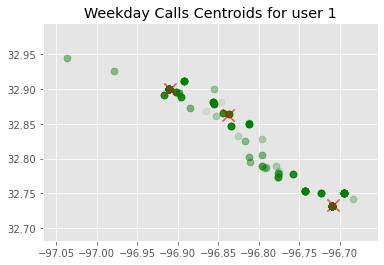

In [22]:
# trực quan hóa các điểm của user1
lons = user1.TowerLon
lats = user1.TowerLat

plt.scatter(x = lons, 
            y = lats,
           c ='green',marker ='o', s = 50, alpha = 0.1)

# trực quan hóa trọng tâm
centers = model.cluster_centers_
plt.scatter(x = centers[:,1],
           y = centers[:,0],
           c = 'red', marker = 'x',s = 150, alpha = 0.7)
# set axis
latmin, latmax, lonmin, lonmax = lats.min(),lats.max(),lons.min(),lons.max()
plt.axis((lonmin-0.03,lonmax+0.03,latmin-0.05,latmax+0.05))

plt.title('Weekday Calls Centroids for user 1')

# Adanved part (15%  of the total score)

**17. Now that you have a system in place, repeat the the steps 12, 14 and 16 for all 10 individuals in the dataset.**

User 1


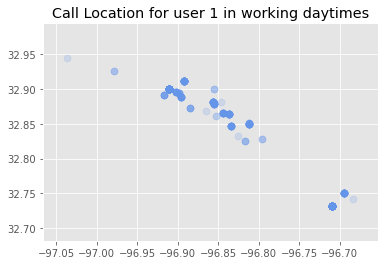

Cluster Analysis Inertia:  0.1589106952378091
------------------------------------------

  Cluster  0
    Centroid  [ 32.9000009  -96.90951639]
    #Samples  959

  Cluster  1
    Centroid  [ 32.73323174 -96.70816184]
    #Samples  306

  Cluster  2
    Centroid  [ 32.86348712 -96.83818346]
    #Samples  140


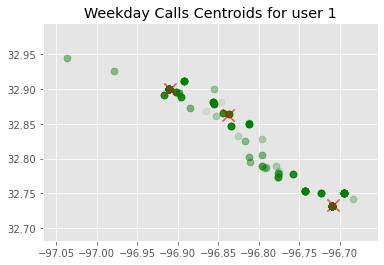



User 2


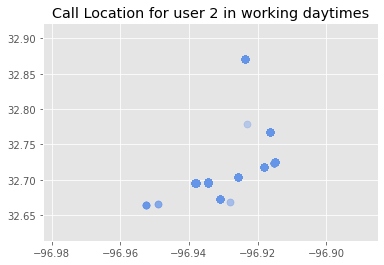

Cluster Analysis Inertia:  0.2657446177583027
------------------------------------------

  Cluster  0
    Centroid  [ 32.73762409 -96.9164561 ]
    #Samples  360

  Cluster  1
    Centroid  [ 32.87096795 -96.92355104]
    #Samples  921

  Cluster  2
    Centroid  [ 32.69557708 -96.93522725]
    #Samples  3121


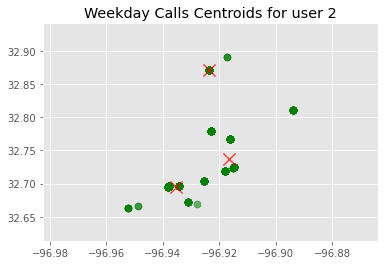



User 3


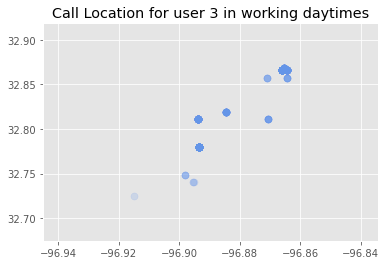

Cluster Analysis Inertia:  0.0195509698781168
------------------------------------------

  Cluster  0
    Centroid  [ 32.77992299 -96.89338791]
    #Samples  846

  Cluster  1
    Centroid  [ 32.86562866 -96.86563953]
    #Samples  197

  Cluster  2
    Centroid  [ 32.81309497 -96.88911725]
    #Samples  88


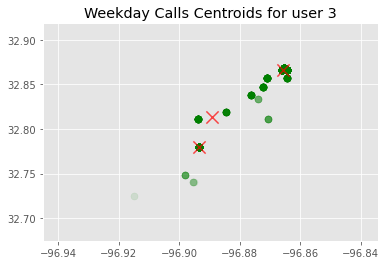



User 4


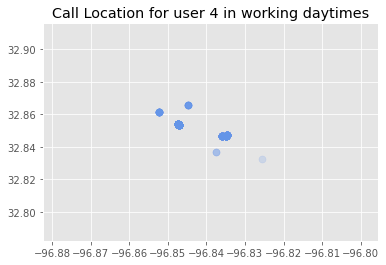

Cluster Analysis Inertia:  0.0013348266129960288
------------------------------------------

  Cluster  0
    Centroid  [ 32.85371225 -96.8472893 ]
    #Samples  701

  Cluster  1
    Centroid  [ 32.84684682 -96.83511392]
    #Samples  241

  Cluster  2
    Centroid  [ 32.86284941 -96.849683  ]
    #Samples  34


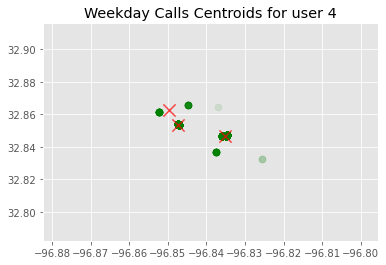



User 5


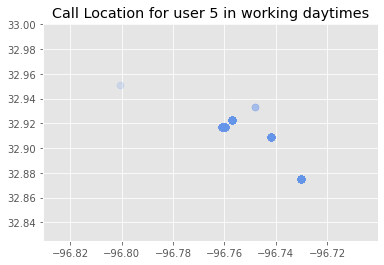

Cluster Analysis Inertia:  0.007583960196992065
------------------------------------------

  Cluster  0
    Centroid  [ 32.875    -96.730278]
    #Samples  169

  Cluster  1
    Centroid  [ 32.92195886 -96.75768121]
    #Samples  827

  Cluster  2
    Centroid  [ 32.909167 -96.741944]
    #Samples  65


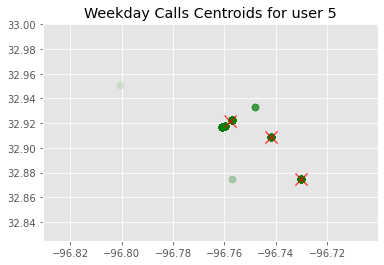



User 6


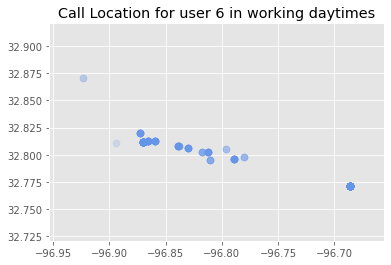

Cluster Analysis Inertia:  0.04745989075758843
------------------------------------------

  Cluster  0
    Centroid  [ 32.81198486 -96.87034706]
    #Samples  456

  Cluster  1
    Centroid  [ 32.770833 -96.685556]
    #Samples  128

  Cluster  2
    Centroid  [ 32.80241723 -96.81450799]
    #Samples  77


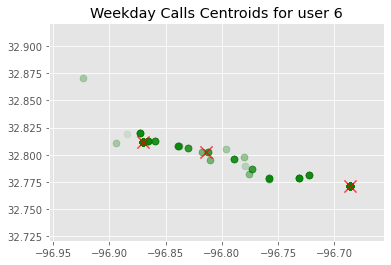



User 7


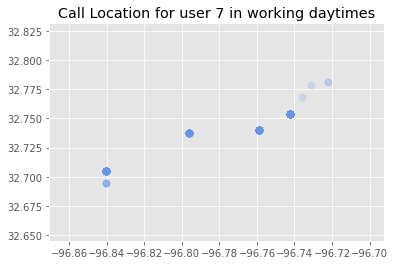

Cluster Analysis Inertia:  0.038284769227121485
------------------------------------------

  Cluster  0
    Centroid  [ 32.75203793 -96.74437494]
    #Samples  707

  Cluster  1
    Centroid  [ 32.70494423 -96.84066398]
    #Samples  184

  Cluster  2
    Centroid  [ 32.7375   -96.796111]
    #Samples  53


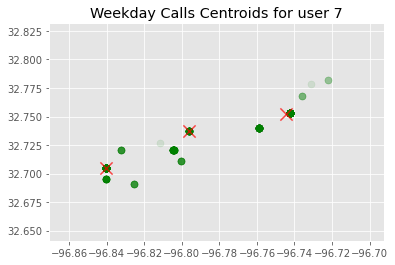



User 8


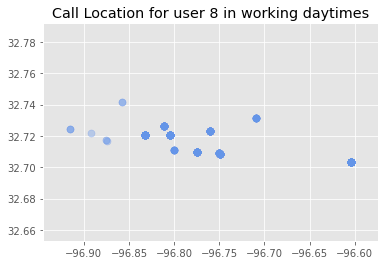

Cluster Analysis Inertia:  0.2467390423843977
------------------------------------------

  Cluster  0
    Centroid  [ 32.72097347 -96.83039184]
    #Samples  1648

  Cluster  1
    Centroid  [ 32.703056 -96.604444]
    #Samples  392

  Cluster  2
    Centroid  [ 32.71410598 -96.75520357]
    #Samples  254


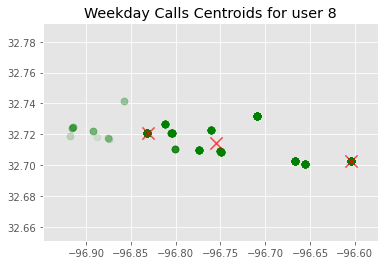



User 9


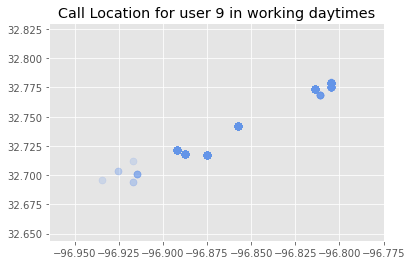

Cluster Analysis Inertia:  0.08053468509540436
------------------------------------------

  Cluster  0
    Centroid  [ 32.72145328 -96.89115458]
    #Samples  3465

  Cluster  1
    Centroid  [ 32.77396536 -96.81270407]
    #Samples  1077

  Cluster  2
    Centroid  [ 32.741889 -96.857611]
    #Samples  298


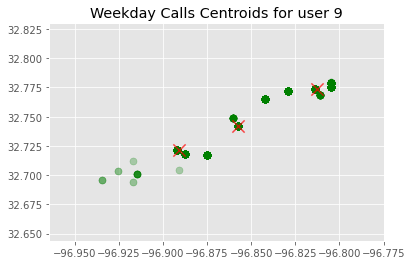



User 10


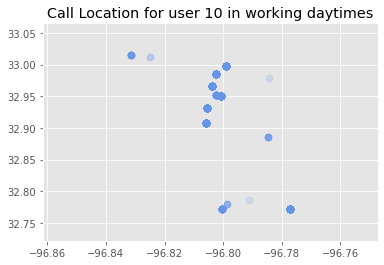

Cluster Analysis Inertia:  0.20362518379546865
------------------------------------------

  Cluster  0
    Centroid  [ 32.77240328 -96.77896656]
    #Samples  576

  Cluster  1
    Centroid  [ 32.98500948 -96.80262338]
    #Samples  2170

  Cluster  2
    Centroid  [ 32.93033402 -96.80360535]
    #Samples  304


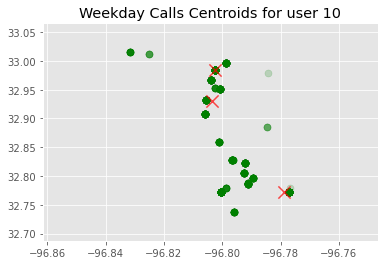

In [23]:
# Lặp lại bước thứ 12, 14 và 16 cho 10 người dùng.

# dùng hàm for để chạy lần lượt cho 10 người
for i,phone in enumerate(phone_list):
    print('User',i+1)
    plt.style.use('ggplot')
    
    # lọc user theo số điện thoại, ngày từ thứ 2-6 và trước 17 h
    user_data = df[df.In == phone]
    user_data_worktime = user_data[(user_data.DOW != 'Sat') & (user_data.DOW != 'Sun')]
    less_17h = user_data_worktime.CallTime < datetime.timedelta(hours =17)
    user_data_worktime = user_data_worktime[less_17h]
    
    # trực quan hóa giống yêu cầu 12
    X = user_data_worktime[['TowerLon','TowerLat']].values
    plt.scatter(x = X[:,0], y = X[:,1] ,c ='cornflowerblue', marker ='o',
               s=50, alpha = 0.2)
#   #set axis
    lonmin, lonmax, latmin, latmax = X[:,0].min(),X[:,0].max(), X[:,1].min(), X[:,1].max()
    plt.axis((lonmin-0.03,lonmax+0.03,latmin-0.05,latmax+0.05))
    plt.title('Call Location for user %s in working daytimes'%str(i+1))
    plt.show()
    
    # k = 3 sử dụng hàm doKMeans giống yêu cầu 14
    model = doKMeans(user_data_worktime, num_clusters=3)
    clusterInfo(model)
    
    # trực quan hóa giống yêu cầu 16
    lons = user_data.TowerLon
    lats = user_data.TowerLat

    plt.scatter(x = lons, 
                y = lats,
               c ='green',marker ='o', s = 50, alpha = 0.1)
    
    centers = model.cluster_centers_
    plt.scatter(x = centers[:,1],
               y = centers[:,0],
               c = 'red', marker = 'x',s = 150, alpha = 0.7)
    
    latmin, latmax, lonmin, lonmax = lats.min(),lats.max(),lons.min(),lons.max()
    plt.axis((lonmin-0.03,lonmax+0.03,latmin-0.05,latmax+0.05))
    plt.title('Weekday Calls Centroids for user %s'%str(i+1))
    plt.show()
    print('\n')